# Rankability Predicting Sensitivity
## March Madness Dataset

Look for new features:</br>
    
Existing features:</br>
    Diversity of P metrics</br>
    Graph measures of tournament matrix as Lapacian</br>
    Eigenvalues of tournament matrix</br>
    
Datasets:</br>
   Lichess:</br>
       API: https://berserk.readthedocs.io/en/master/ </br>
       Look for tournaments, grab games played in that time frame and create D matricies</br>
       API is pretty simple we just need to build a scraping script.</br>
   
   Sumo:
   Data: https://data.world/cervus/sumo-results </br>
   It's literally just CSVs, so grab to PANDAS and build D from columns
   Bad news: Have to make an account to download data :( /s

## Outline of the Experiment

 1. Load in the game-by-game data for each year from 2002-2018
 2. For each year, construct multiple D matrices using increasing percentages of the games for that year.</br>_(For instance in the simplest case, construct a D matrix using only the first half of the season, then a D matrix with the full season.)_
 2. Produce Massey rankings for each D matrix and calculate the Kendall tau between rankings from the same year </br>_(These kendall taus represent the amount that the ranking changed when more data was included)_
 3. For each year, measure features of the restricted dataset (in the simple case, D constructed from 50% of the games) and create a dataset of these early-measurable features.
 4. Evaluate whether these early-measurable features can be used to predict the amount that rankings changed after including more data (Kendall taus).

In [157]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [158]:
import copy
import os
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import pearsonr
from scipy.stats import skew
from tqdm import tqdm
import matplotlib.pyplot as plt

In [159]:
from pathlib import Path
home = str(Path.home())
home

'/disk/home/amy'

In [160]:
import sys
sys.path.insert(0,"%s/rankability_toolbox_dev"%home)
import pyrankability

In [6]:
sys.path.insert(0,"%s/sensitivity_study/src"%home)
from sensitivity_tests import *
from utilities import *
from base import *

In [181]:
games={}
years = ["2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018"]
for year in years:
    games[year] = read_data('../data/%steams.txt'%year,'../data/%sgames.txt'%year,'../data/%sMadnessTeams.txt'%year)
print(year)
games[year]

2018


,team2,team1,notsure1,date,H_A_N1,points1,H_A_N2,points2,team1_name,team2_name,team1_madness,team2_madness
0,1,16,737011,2017-11-13,1,83,-1,69,Arkansas_St,Abilene_Chr,0,0
1,1,41,737114,2018-02-24,-1,74,1,72,Cent_Arkansas,Abilene_Chr,0,0
3,1,143,737018,2017-11-20,-1,75,1,67,Lipscomb,Abilene_Chr,1,0
4,1,143,737045,2017-12-17,1,67,-1,65,Lipscomb,Abilene_Chr,1,0
5,1,199,737056,2017-12-28,1,77,-1,74,New_Orleans,Abilene_Chr,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5535,351,318,737048,2017-12-20,1,91,-1,74,Utah_St,Youngstown_St,0,0
5536,351,339,737086,2018-01-27,1,85,-1,67,WI_Green_Bay,Youngstown_St,0,0
5537,351,340,737084,2018-01-25,1,66,-1,55,WI_Milwaukee,Youngstown_St,0,0
5538,351,347,737074,2018-01-15,1,77,-1,67,Wright_St,Youngstown_St,1,0


In [274]:
# Note to future self: Parameters from FODS paper but might need to be optimized
direct_thress = [0,1,2]
spread_thress = [0,2,3,4,5]
weight_indirects = [0.25,0.5,0.75,1]
Ds = {}
# fracs represent how much of the data to include
fracs = [0.5,0.75,1.] # 25% of total data added per step
#fracs = [0.64, 0.8, 1.] # 25% of current data added per step
#pairs = list(zip(fracs[:-1], fracs[1:]))
#pair_to_predict = pairs[-1]

In [275]:
import itertools
import joblib

In [276]:
load = False

In [ ]:
if not load:
    for year in tqdm(games.keys()):
        Ds[year] = {}
        madness_teams = np.unique(list(games[year].team1_name.loc[games[year].team1_madness == 1]) + list(games[year].team2_name.loc[games[year].team2_madness == 1]))
        game_list = list(games[year].index)

        game_df = pd.DataFrame({"team1_name":games[year]['team1_name'],
                                "team1_score":games[year]['points1'],
                                "team1_H_A_N": games[year]['H_A_N1'],
                                "team2_name":games[year]['team2_name'],
                                "team2_score":games[year]['points2'],
                                "team2_H_A_N": games[year]['H_A_N1'],
                                "date": games[year]['date']
                               }).sort_values(by='date').drop('date',axis=1)
        # support_map_vectorized_direct_indirect_weighted implements our common approach to looking for evidence of direct and indirect dominance
        # I'm just using an annonymous function because the helper function V_count_vectorized expects a function with one argument
        for frac,direct_thres,spread_thres,weight_indirect in itertools.product(fracs,direct_thress,spread_thress,weight_indirects):
            upper = int(len(game_df)*frac)
            game_df_sample = game_df.iloc[:upper,:]
            map_func = lambda linked: pyrankability.construct.support_map_vectorized_direct_indirect_weighted(linked,direct_thres=direct_thres,spread_thres=spread_thres,weight_indirect=weight_indirect)
            Ds[year][(frac,direct_thres,spread_thres,weight_indirect)] = pyrankability.construct.V_count_vectorized(game_df_sample,map_func).loc[madness_teams,madness_teams]





  0%|          | 0/17 [00:00<?, ?it/s]/disk/home/amy/rankability_toolbox_dev/pyrankability/construct.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df["game"] = list(game_df.index)


In [ ]:
if not load:
    massey_rankings = {}
    massey_taus = {}
    massey_results = pd.DataFrame(columns=pairs+["Year"]).set_index("Year")
    colley_rankings = {}
    colley_taus = {}
    colley_results = pd.DataFrame(columns=pairs+["Year"]).set_index("Year")

    massey_rankings = {}
    colley_rankings = {}

    for year in tqdm(Ds.keys()):
        madness_teams = list(np.unique(list(games[year].team1_name.loc[games[year].team1_madness == 1]) + list(games[year].team2_name.loc[games[year].team2_madness == 1])))
        game_list = list(games[year].index)

        game_df = pd.DataFrame({"team1_name":games[year]['team1_name'],
                                "team1_score":games[year]['points1'],
                                "team1_H_A_N": games[year]['H_A_N1'],
                                "team2_name":games[year]['team2_name'],
                                "team2_score":games[year]['points2'],
                                "team2_H_A_N": games[year]['H_A_N1'],
                                "date": games[year]['date']
                               }).sort_values(by='date').drop('date',axis=1)
        
        massey_rankings[year] = pd.DataFrame(columns=["frac","direct_thres","spread_thres","weight_indirect"]+madness_teams)
        colley_rankings[year] = pd.DataFrame(columns=["frac","direct_thres","spread_thres","weight_indirect"]+madness_teams)
        c=0
        for frac,direct_thres,spread_thres,weight_indirect in Ds[year].keys():
            upper = int(len(game_df)*frac)
            game_df_sample = game_df.iloc[:upper,:]
            
            D1 = Ds[year][(frac,direct_thres,spread_thres,weight_indirect)]
            
            map_func = lambda linked: pyrankability.construct.colley_matrices(linked,direct_thres=direct_thres,spread_thres=spread_thres,weight_indirect=weight_indirect)
            colley_matrix,colley_b = pyrankability.construct.map_vectorized(game_df_sample,map_func)
            colley_matrix = colley_matrix.loc[madness_teams,madness_teams]
            colley_b = colley_b.loc[madness_teams]
            ranking1,r1 = pyrankability.construct.ranking_from_matrices(colley_matrix.fillna(0),colley_b)
            
            map_func = lambda linked: pyrankability.construct.massey_matrices(linked,direct_thres=direct_thres,spread_thres=spread_thres,weight_indirect=weight_indirect)
            massey_matrix,massey_b = pyrankability.construct.map_vectorized(game_df_sample,map_func)
            massey_matrix = massey_matrix.loc[madness_teams,madness_teams]
            massey_b = massey_b.loc[madness_teams]
            ranking2,r2 = pyrankability.construct.ranking_from_matrices(massey_matrix.fillna(0),massey_b.fillna(0))
            
            #ranking1 = MasseyRankingAlgorithm().rank(D1.fillna(0).values)
            #ranking2 = ColleyRankingAlgorithm().rank(D1.fillna(0).values)
            massey_rankings[year] = massey_rankings[year].append(pd.Series([frac,direct_thres,spread_thres,weight_indirect]+list(ranking1),name=c,index=massey_rankings[year].columns))
            colley_rankings[year] = colley_rankings[year].append(pd.Series([frac,direct_thres,spread_thres,weight_indirect]+list(ranking2),name=c,index=colley_rankings[year].columns))
            c+=1
    joblib.dump({"colley_rankings":colley_rankings,"massey_rankings":massey_rankings,"Ds":Ds},"checkpoint1.joblib.z");

In [ ]:
if load:
    loaded = joblib.load('checkpoint1.joblib.z')
    colley_rankings=loaded['colley_rankings']
    massey_rankings=loaded['massey_rankings']
    Ds=loaded['Ds']

## Compute Kendall W for each year

In [269]:
import kendall_w as kw

def results_to_frame(results,method):
    t = results.to_frame()
    t.columns=['w']
    t['Method'] = method
    t['Year']=year
    t.reset_index(inplace=True)
    return t

ws = pd.DataFrame(columns=['frac','w','Method','Year'])
for year in tqdm(Ds.keys()):
    madness_teams = list(np.unique(list(games[year].team1_name.loc[games[year].team1_madness == 1]) + list(games[year].team2_name.loc[games[year].team2_madness == 1])))
    results = colley_rankings[year].groupby(['frac']).apply(lambda df: kw.compute_w(df[madness_teams].astype(int).T.values.tolist()))
    ws = ws.append(results_to_frame(results,'Colley'))
    results = massey_rankings[year].groupby(['frac']).apply(lambda df: kw.compute_w(df[madness_teams].astype(int).T.values.tolist()))
    ws = ws.append(results_to_frame(results,'Massey'))
ws





  0%|          | 0/17 [00:00<?, ?it/s]



 35%|███▌      | 6/17 [00:00<00:00, 56.18it/s]



100%|██████████| 17/17 [00:00<00:00, 55.26it/s]


,frac,w,Method,Year
0,0.5,0.879701,Colley,2002
0,0.5,0.344765,Massey,2002
0,0.5,0.904050,Colley,2003
0,0.5,0.418254,Massey,2003
0,0.5,0.956643,Colley,2004
0,0.5,0.419784,Massey,2004
0,0.5,0.912743,Colley,2005
0,0.5,0.390278,Massey,2005
0,0.5,0.886441,Colley,2006
0,0.5,0.471639,Massey,2006


In [270]:
import altair as alt

alt.Chart(ws).mark_bar().encode(
    x='Method',
    y='w',
    color='Method'#,
    #column='Year:N'
).properties(
    width=180,
    height=180
).facet(row='Year:N',column='frac')

alt.FacetChart(...)

In [271]:
ws.groupby(['frac','Method'])['w'].std().to_frame().reset_index()

,frac,Method,w
0,0.5,Colley,0.043079
1,0.5,Massey,0.063202


In [272]:
import altair as alt

alt.Chart(ws.groupby(['frac','Method'])['w'].std().to_frame().reset_index()).mark_bar().encode(
    x='Method',
    y=alt.Y('w',title="Stdev w"),
    color='Method'#,
    #column='Year:N'
).properties(
    width=180,
    height=180
).facet(column='frac')

alt.FacetChart(...)

In [273]:
import altair as alt

alt.Chart(ws.groupby(['frac','Method'])['w'].mean().to_frame().reset_index()).mark_bar().encode(
    x='Method',
    y=alt.Y('w',title="Mean w"),
    color='Method'#,
    #column='Year:N'
).properties(
    width=180,
    height=180
).facet(column='frac')

alt.FacetChart(...)

In [ ]:
"""
col_names = [
    'Year',
    '# X* frac',
    'k',
    '# X* frac top 40',
    'kendall_w',
    'p_lowerbound',
    'max_L2_dist',
    'mean_L2_dist',
    'min_tau',
    'mean_tau',
    'max_eigenval',
    'min_eigenval',
    'Pair'
]

all_score_df = pd.DataFrame(columns=col_names)

c=0
for year in tqdm(games.keys()):
    # the support matrix for a pair for a given year
    V = Ds[year][pair_to_predict[0]]
    # print(V.fillna(0.0))
    vals, vecs = np.linalg.eig(V.fillna(0.0).to_numpy())
    determinant = np.prod(vals)
    trace = np.sum(vals)
    max_eigenval = np.real(np.max(vals))
    min_eigenval = np.real(np.min(vals))
    dsGraph = nx.from_numpy_matrix(V.fillna(0.0).to_numpy())
    
    # nodesranked = nx.voterank(dsGraph)
    # print(nodesranked)
    
    rresults = rankability_results.iloc[c,:]
    k = rresults['k']
    details = df_details[c]
    x = pd.DataFrame(details['x'],index=V.index,columns=V.columns)
    r = x.sum(axis=0)
    order = np.argsort(r)
    xstar = x.iloc[order,:].iloc[:,order]
    xstar.loc[:,:] = pyrankability.common.threshold_x(xstar.values)
    inxs = np.triu_indices(len(xstar),k=1)
    xstar_upper = xstar.values[inxs[0],inxs[1]]
    nfrac_upper = sum((xstar_upper > 0) & (xstar_upper < 1))
    flat_frac = ((xstar > 0) & (xstar < 1)).sum(axis=0)
    nfrac_top_40 = flat_frac.iloc[:40].sum()
    entry_data = [
        year,
        nfrac_upper*2,
        k,
        nfrac_top_40,
        rresults["kendall_w"],
        rresults["p_lowerbound"],
        rresults["max_L2_dist"],
        rresults["mean_L2_dist"],
        rresults["min_tau"],
        rresults["mean_tau"],
        max_eigenval, 
        min_eigenval,
        pair
    ]
    """

In [129]:
summaries = pd.DataFrame(columns=["k_best","k_worst","k_best/k_worst","frac","threshold","nfrac_upper*2","nfrac_top_40","max_eigenval","min_eigenval"])

def summarize_hillside(D,details,name,frac,threshold):
    perm = np.array(details['P'][0])
    C = pyrankability.construct.C_count(D,threshold=0)
    k_worst = np.sum(np.triu(C.iloc[perm[::-1],:].iloc[:,perm[::-1]]))
    C = pyrankability.construct.C_count(D,threshold=threshold)
    k_best = np.sum(np.triu(C.iloc[perm,:].iloc[:,perm]))
    
    V = D
    vals, vecs = np.linalg.eig(V.fillna(0.0).to_numpy())
    determinant = np.prod(vals)
    trace = np.sum(vals)
    max_eigenval = np.real(np.max(vals))
    min_eigenval = np.real(np.min(vals))
    dsGraph = nx.from_numpy_matrix(V.fillna(0.0).to_numpy())
    
    # nodesranked = nx.voterank(dsGraph)
    # print(nodesranked)
    
    x = pd.DataFrame(details['x'],index=V.index,columns=V.columns)
    r = x.sum(axis=0)
    order = np.argsort(r)
    xstar = x.iloc[order,:].iloc[:,order]
    xstar.loc[:,:] = pyrankability.common.threshold_x(xstar.values)
    inxs = np.triu_indices(len(xstar),k=1)
    xstar_upper = xstar.values[inxs[0],inxs[1]]
    nfrac_upper = sum((xstar_upper > 0) & (xstar_upper < 1))
    flat_frac = ((xstar > 0) & (xstar < 1)).sum(axis=0)
    nfrac_top_40 = flat_frac.iloc[:40].sum()
    entry_data = [
        nfrac_upper*2,
        nfrac_top_40,
        max_eigenval, 
        min_eigenval
    ]
    
    s = pd.Series([k_best,k_worst,k_best/k_worst,frac,threshold]+entry_data,index=summaries.columns,name=name)
    return s

exp_ks = {}
exp_details = {}
thresholds = [0,0.5,1]
for year in tqdm(Ds.keys()):
    for frac in fracs:
        D = Ds[year][frac,0,0,0.25]
        exp_ks[year],exp_details[year] = pyrankability.rank.solve(D,method='hillside', lazy=False, cont=True)
        for threshold in thresholds:
            summaries = summaries.append(summarize_hillside(D,exp_details[year],year,frac,threshold))
summaries.index.name="Year"
summaries.reset_index(inplace=True)
summaries

  0%|          | 0/17 [00:00<?, ?it/s]/disk/home/amy/rankability_toolbox_dev/pyrankability/construct.py:80: RuntimeWarning: invalid value encountered in greater
  mask1 = np.abs(S[:,j]-S[:,i])>threshold # smooth things out and don't worry about warnings here
/disk/home/amy/rankability_toolbox_dev/pyrankability/construct.py:81: RuntimeWarning: invalid value encountered in greater
  mask2 = np.abs(S[j,:]-S[i,:])>threshold # smooth things out and don't worry about warnings here
100%|██████████| 17/17 [04:27<00:00, 15.73s/it]


,Year,k_best,k_worst,k_best/k_worst,frac,threshold,nfrac_upper*2,nfrac_top_40,max_eigenval,min_eigenval
0,2006,7209.0,16826.0,0.428444,0.50,0.0,220.0,107.0,3.122256,-1.148105
1,2006,2479.0,16826.0,0.147332,0.50,0.5,220.0,107.0,3.122256,-1.148105
2,2006,304.0,16826.0,0.018067,0.50,1.0,220.0,107.0,3.122256,-1.148105
3,2006,18010.0,36154.0,0.498147,0.75,0.0,30.0,18.0,6.633481,-1.728323
4,2006,5467.0,36154.0,0.151214,0.75,0.5,30.0,18.0,6.633481,-1.728323
...,...,...,...,...,...,...,...,...,...,...
148,2018,6982.0,41177.0,0.169561,0.75,0.5,36.0,24.0,9.282724,-2.102322
149,2018,2451.0,41177.0,0.059524,0.75,1.0,36.0,24.0,9.282724,-2.102322
150,2018,30196.0,52517.0,0.574976,1.00,0.0,76.0,68.0,19.424785,-3.304245
151,2018,12944.0,52517.0,0.246473,1.00,0.5,76.0,68.0,19.424785,-3.304245


In [130]:
summaries.head()

,Year,k_best,k_worst,k_best/k_worst,frac,threshold,nfrac_upper*2,nfrac_top_40,max_eigenval,min_eigenval
0,2006,7209.0,16826.0,0.428444,0.50,0.0,220.0,107.0,3.122256,-1.148105
1,2006,2479.0,16826.0,0.147332,0.50,0.5,220.0,107.0,3.122256,-1.148105
2,2006,304.0,16826.0,0.018067,0.50,1.0,220.0,107.0,3.122256,-1.148105
3,2006,18010.0,36154.0,0.498147,0.75,0.0,30.0,18.0,6.633481,-1.728323
4,2006,5467.0,36154.0,0.151214,0.75,0.5,30.0,18.0,6.633481,-1.728323


In [131]:
results = summaries.reset_index().set_index(['Year','frac']).join(ws.set_index(['Year','frac']))
results

index   k_best  k_worst  k_best/k_worst  threshold  nfrac_upper*2  \
Year frac                                                                      
2002 0.5       9   9025.0  18461.0        0.488868        0.0          210.0   
     0.5       9   9025.0  18461.0        0.488868        0.0          210.0   
     0.5      10   2609.0  18461.0        0.141325        0.5          210.0   
     0.5      10   2609.0  18461.0        0.141325        0.5          210.0   
     0.5      11    300.0  18461.0        0.016250        1.0          210.0   
...          ...      ...      ...             ...        ...            ...   
2018 1.0     150  30196.0  52517.0        0.574976        0.0           76.0   
     1.0     151  12944.0  52517.0        0.246473        0.5           76.0   
     1.0     151  12944.0  52517.0        0.246473        0.5           76.0   
     1.0     152   8676.0  52517.0        0.165204        1.0           76.0   
     1.0     152   8676.0  52517.0        0.165204        1.0           76.0   

           nfrac_top_40  max_eigenval  min_eigenval         w  Method  
Year frac                                                              
2002 0.5          204.0      3.884009     -1.158749  0.445753  Colley  
     0.5          204.0      3.884009     -1.158749  0.265629  Massey  
     0.5          204.0      3.884009     -1.158749  0.445753  Colley  
     0.5          204.0      3.884009     -1.158749  0.265629  Massey  
     0.5          204.0      3.884009     -1.158749  0.445753  Colley  
...                 ...           ...           ...       ...     ...  
2018 1.0           68.0     19.424785     -3.304245  0.298285  Massey  
     1.0           68.0     19.424785     -3.304245  0.391570  Colley  
     1.0           68.0     19.424785     -3.304245  0.298285  Massey  
     1.0           68.0     19.424785     -3.304245  0.391570  Colley  
     1.0           68.0     19.424785     -3.304245  0.298285  Massey  

[306 rows x 11 columns]

In [141]:
from scipy.stats import pearsonr

fields_to_test = ["k_best","k_worst","k_best/k_worst","nfrac_upper*2","nfrac_top_40","max_eigenval","min_eigenval"]
corr_results = {}
for field in fields_to_test:
    corr_results[field] = pd.DataFrame(results.reset_index().groupby(['threshold','frac','Method']).apply(lambda df: pd.Series(pearsonr(df['w'], df[field]),index=['r','pval'])))


In [142]:
from IPython.display import display, Markdown, Latex

for field in corr_results.keys():
    display(Markdown(f'## {field}'))
    display(corr_results[field])

## k_best

r      pval
threshold frac Method                    
0.0       0.50 Colley -0.036525  0.889316
               Massey  0.161286  0.536299
          0.75 Colley  0.110144  0.673881
               Massey  0.316344  0.216070
          1.00 Colley -0.275180  0.285076
               Massey  0.234171  0.365656
0.5       0.50 Colley -0.218003  0.400593
               Massey  0.140450  0.590814
          0.75 Colley  0.086301  0.741900
               Massey  0.167000  0.521760
          1.00 Colley -0.363277  0.151784
               Massey  0.233535  0.366999
1.0       0.50 Colley  0.340482  0.181130
               Massey -0.119306  0.648334
          0.75 Colley  0.156882  0.547632
               Massey  0.008626  0.973788
          1.00 Colley -0.365244  0.149415
               Massey  0.107083  0.682494

## k_worst

r      pval
threshold frac Method                    
0.0       0.50 Colley -0.333775  0.190434
               Massey  0.173070  0.506515
          0.75 Colley -0.006485  0.980294
               Massey  0.164613  0.527813
          1.00 Colley -0.367758  0.146423
               Massey  0.261626  0.310413
0.5       0.50 Colley -0.333775  0.190434
               Massey  0.173070  0.506515
          0.75 Colley -0.006485  0.980294
               Massey  0.164613  0.527813
          1.00 Colley -0.367758  0.146423
               Massey  0.261626  0.310413
1.0       0.50 Colley -0.333775  0.190434
               Massey  0.173070  0.506515
          0.75 Colley -0.006485  0.980294
               Massey  0.164613  0.527813
          1.00 Colley -0.367758  0.146423
               Massey  0.261626  0.310413

## k_best/k_worst

r      pval
threshold frac Method                    
0.0       0.50 Colley  0.620768  0.007833
               Massey  0.003681  0.988814
          0.75 Colley  0.304672  0.234423
               Massey  0.436081  0.080138
          1.00 Colley  0.233570  0.366924
               Massey -0.059153  0.821579
0.5       0.50 Colley  0.284963  0.267593
               Massey -0.055196  0.833351
          0.75 Colley  0.244964  0.343319
               Massey  0.058131  0.824618
          1.00 Colley -0.165821  0.524745
               Massey  0.041727  0.873663
1.0       0.50 Colley  0.581116  0.014428
               Massey -0.226250  0.382554
          0.75 Colley  0.322687  0.206497
               Massey -0.171041  0.511587
          1.00 Colley -0.198907  0.444068
               Massey -0.129167  0.621248

## nfrac_upper*2

r      pval
threshold frac Method                    
0.0       0.50 Colley  0.250103  0.332964
               Massey -0.048832  0.852356
          0.75 Colley  0.240499  0.352464
               Massey  0.127018  0.627114
          1.00 Colley -0.078471  0.764664
               Massey -0.163321  0.531101
0.5       0.50 Colley  0.250103  0.332964
               Massey -0.048832  0.852356
          0.75 Colley  0.240499  0.352464
               Massey  0.127018  0.627114
          1.00 Colley -0.078471  0.764664
               Massey -0.163321  0.531101
1.0       0.50 Colley  0.250103  0.332964
               Massey -0.048832  0.852356
          0.75 Colley  0.240499  0.352464
               Massey  0.127018  0.627114
          1.00 Colley -0.078471  0.764664
               Massey -0.163321  0.531101

## nfrac_top_40

r      pval
threshold frac Method                    
0.0       0.50 Colley  0.259805  0.313915
               Massey -0.090691  0.729221
          0.75 Colley  0.221049  0.393878
               Massey  0.210386  0.417651
          1.00 Colley -0.189282  0.466858
               Massey -0.030818  0.906532
0.5       0.50 Colley  0.259805  0.313915
               Massey -0.090691  0.729221
          0.75 Colley  0.221049  0.393878
               Massey  0.210386  0.417651
          1.00 Colley -0.189282  0.466858
               Massey -0.030818  0.906532
1.0       0.50 Colley  0.259805  0.313915
               Massey -0.090691  0.729221
          0.75 Colley  0.221049  0.393878
               Massey  0.210386  0.417651
          1.00 Colley -0.189282  0.466858
               Massey -0.030818  0.906532

## max_eigenval

r      pval
threshold frac Method                    
0.0       0.50 Colley  0.392786  0.118856
               Massey  0.070427  0.788243
          0.75 Colley  0.197470  0.447434
               Massey  0.190297  0.464426
          1.00 Colley -0.377021  0.135754
               Massey -0.013810  0.958048
0.5       0.50 Colley  0.392786  0.118856
               Massey  0.070427  0.788243
          0.75 Colley  0.197470  0.447434
               Massey  0.190297  0.464426
          1.00 Colley -0.377021  0.135754
               Massey -0.013810  0.958048
1.0       0.50 Colley  0.392786  0.118856
               Massey  0.070427  0.788243
          0.75 Colley  0.197470  0.447434
               Massey  0.190297  0.464426
          1.00 Colley -0.377021  0.135754
               Massey -0.013810  0.958048

## min_eigenval

r      pval
threshold frac Method                    
0.0       0.50 Colley -0.334446  0.189490
               Massey  0.208531  0.421862
          0.75 Colley -0.232215  0.369790
               Massey  0.320309  0.210053
          1.00 Colley -0.071715  0.784456
               Massey  0.080530  0.758660
0.5       0.50 Colley -0.334446  0.189490
               Massey  0.208531  0.421862
          0.75 Colley -0.232215  0.369790
               Massey  0.320309  0.210053
          1.00 Colley -0.071715  0.784456
               Massey  0.080530  0.758660
1.0       0.50 Colley -0.334446  0.189490
               Massey  0.208531  0.421862
          0.75 Colley -0.232215  0.369790
               Massey  0.320309  0.210053
          1.00 Colley -0.071715  0.784456
               Massey  0.080530  0.758660

In [151]:
slopes = pd.DataFrame(results.dropna().reset_index().groupby(['frac','Method','Year']).apply(lambda df: np.polyfit(df['threshold'], df['k_best/k_worst'],deg=1)))
slopes

0
frac Method Year                                             
0.5  Colley 2002    [-0.4726179513569146, 0.4517902605492661]
            2003  [-0.42279411764705893, 0.40963811995386407]
            2004   [-0.3611164091804946, 0.34882488821073604]
            2005   [-0.36234956662717455, 0.3467086529068196]
            2006    [-0.4103767978129087, 0.4031360196521259]
...                                                       ...
1.0  Massey 2014   [-0.38604181264156173, 0.4682358628406308]
            2015   [-0.3821459676014631, 0.45756546478546134]
            2016   [-0.40561195391810206, 0.5004589722281066]
            2017    [-0.4015791406536908, 0.4896009303464318]
            2018    [-0.4097720738046728, 0.5337700173277226]

[102 rows x 1 columns]

In [138]:
slopes = pd.DataFrame(results.dropna().reset_index().groupby(['frac','Method','Year']).apply(lambda df: np.polyfit(df['threshold'], df['k_best/k_worst'], 1)[0]))
slopes.columns = ['k_best/k_worst slope']
slopes

k_best/k_worst slope
frac Method Year                      
0.5  Colley 2002             -0.472618
            2003             -0.422794
            2004             -0.361116
            2005             -0.362350
            2006             -0.410377
...                                ...
1.0  Massey 2014             -0.386042
            2015             -0.382146
            2016             -0.405612
            2017             -0.401579
            2018             -0.409772

[102 rows x 1 columns]

In [143]:
slopes.join(results.dropna().reset_index().set_index(['frac','Method','Year'])[['w']]).drop_duplicates().reset_index().groupby(['frac','Method']).apply(
    lambda df: pd.Series(pearsonr(df['w'], df['k_best/k_worst slope']),index=['r','pval']))

r      pval
frac Method                    
0.50 Colley -0.589342  0.012789
     Massey -0.027775  0.915728
0.75 Colley -0.266198  0.301721
     Massey -0.507318  0.037648
1.00 Colley -0.419424  0.093752
     Massey -0.017423  0.947082

In [98]:
results.reset_index().set_index('threshold').loc[0].groupby(['frac','Method']).apply(
    lambda df: pearsonr(df['w'], df['k_best/k_worst']))

frac  Method
0.50  Colley    (0.6141935529350092, 0.008714943598028496)
      Massey     (0.006909206751665014, 0.979004024671963)
0.75  Colley     (0.3012924718490593, 0.23991591212491567)
      Massey     (0.4390644716031226, 0.07786032052978277)
1.00  Colley     (0.2368855131083636, 0.35996368346583485)
      Massey    (-0.05720998593782581, 0.8273563690613008)
dtype: object

In [99]:
results.reset_index().set_index('threshold').loc[0].groupby(['frac','Method']).apply(
    lambda df: pearsonr(df['w'], df['(k_worst-k_best)/k_worst']))

frac  Method
0.50  Colley    (-0.6141935529350092, 0.008714943598028496)
      Massey    (-0.006909206751665538, 0.9790040246719613)
0.75  Colley     (-0.3012924718490593, 0.23991591212491567)
      Massey     (-0.4390644716031229, 0.07786032052978259)
1.00  Colley      (-0.2368855131083633, 0.3599636834658355)
      Massey     (0.057209985937825655, 0.8273563690613005)
dtype: object

In [292]:
pearsonr(summaries['w'], summaries['k_best/k_worst'])

(0.6141935529350092, 0.008714943598028496)

In [282]:
results = pd.DataFrame({"w":ws.loc[0.5],"k":pd.Series(exp_ks)})
results.corr(method='kendall')

,w,k
w,1.000000,-0.058824
k,-0.058824,1.000000


## Digging into specific years

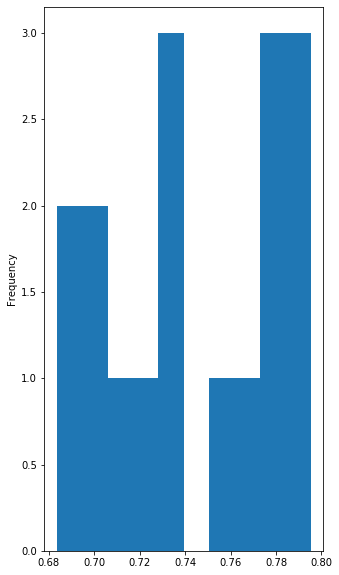

In [195]:
results[(0.5,0.75)].plot.hist()

In [197]:
idx_min = results[(0.5,0.75)].idxmin()
idx_max = results[(0.5,0.75)].idxmax()
idx_min,idx_max

('2009', '2010')

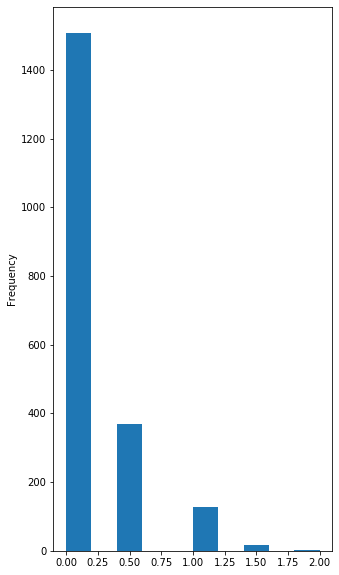

In [198]:
Ds[idx_min][0.5].stack().plot.hist()

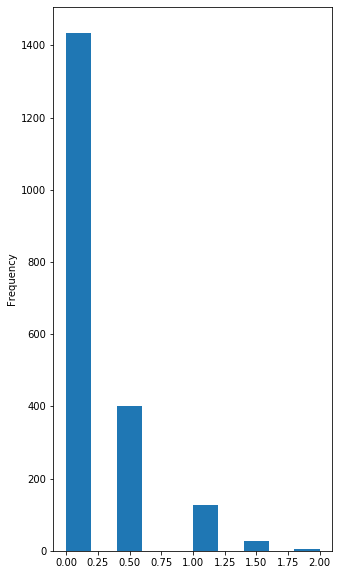

In [199]:
Ds[idx_max][0.5].stack().plot.hist()

In [200]:
idx_min

'2009'

In [201]:
k_max,details_max = pyrankability.rank.solve(Ds[idx_max][0.5],method='hillside', lazy=False, cont=False)

In [202]:
k_min,details_min = pyrankability.rank.solve(Ds[idx_min][0.5],method='hillside', lazy=False, cont=False)

In [203]:
k_max,k_min

(7497.0, 7307.0)

In [204]:
Ds[idx_min][0.5].shape

(64, 64)

In [205]:
def summarize_hillside(D,perm):
    C = pyrankability.construct.C_count(D,threshold=0)
    k_best = np.sum(np.triu(C.iloc[perm,:].iloc[:,perm]))
    k_worst = np.sum(np.triu(C.iloc[perm[::-1],:].iloc[:,perm[::-1]]))
    return k_best,k_worst,k_best/k_worst

In [206]:
summarize_hillside(Ds[idx_min][0.5],list(details_min['P'][0]))

(7307.0, 17548.0, 0.416400729427855)

In [207]:
summarize_hillside(Ds[idx_max][0.5],list(details_max['P'][0]))

(7497.0, 17799.0, 0.42120343839541546)

In [96]:
Dordered_min = Ds[idx_min][0.5].iloc[list(details_min['P'][0]),:].iloc[:,list(details_min['P'][0])]
Dordered_min

team2,Duke,Wisconsin,Texas,Illinois,Pittsburgh,Northern_Iowa,Florida,Memphis,Tennessee,Connecticut,...,California,Albany_NY,Hampton,Alabama,San_Diego_St,Oral_Roberts,Belmont,Southern_Univ,Monmouth_NJ,Kent
team1,,,,,,,,,,,,,,,,,,,,,
Duke,NaN,0.5,1.0,NaN,NaN,NaN,0.0,1.5,0.0,NaN,...,NaN,0.0,0.5,0.5,NaN,0.5,NaN,0.5,1.0,NaN
Wisconsin,0.0,NaN,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,...,NaN,NaN,0.5,0.0,NaN,1.0,NaN,0.5,NaN,NaN
Texas,0.0,0.0,NaN,0.5,NaN,0.5,NaN,1.0,0.0,NaN,...,NaN,NaN,NaN,0.5,NaN,NaN,NaN,1.0,NaN,0.0
Illinois,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,0.5
Pittsburgh,NaN,1.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,...,0.5,0.0,NaN,0.5,NaN,NaN,NaN,NaN,1.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Oral_Roberts,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.5,1.0,NaN
Belmont,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN
Southern_Univ,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [97]:
pyrankability.plot.show_hillside(Ds[idx_min][0.5],details_min['P'][0])

alt.Chart(...)

In [98]:
pyrankability.plot.show_hillside(Ds[idx_max][0.5],details_max['P'][0])

alt.Chart(...)

## Back to general studies

In [19]:
# Note: what do the contents of this matrix mean??
# Ds['2018'][1.0]

In [20]:
df_details = []
# This function constructs a dataframe of features
# (collected from the first D matrix of each pair)
# To be used to predict the movement of the pair (kendall tau of rankings)
def get_rankability_results(n_restarts=250):
    df_ks = []
    df_years = []
    df_fracs = []
    df_p_stats = {}
    for year in tqdm(games.keys()):
        D = Ds[year][pair_to_predict[0]].fillna(0)
        k,details = pyrankability.rank.solve(D,method='lop', num_random_restarts=n_restarts, lazy=False, cont=True)
        p_stats = get_P_stats(details["P"])
        for name, val in p_stats.items():
            if name not in df_p_stats:
                df_p_stats[name] = []
            df_p_stats[name].append(val)
        df_ks.append(k)
        df_years.append(year)
        df_fracs.append(pair_to_predict[0])
        df_details.append(details)

    results_temp = {"k":df_ks,"Year":df_years,"Fraction":df_fracs}
    for key, val in df_p_stats.items():
        if key in results_temp:
            raise ValueError("Duplicate column name! Fix collision before moving on!")
        results_temp[key] = val

    return pd.DataFrame(results_temp)

In [21]:
rankability_results = get_rankability_results(n_restarts=2)
rankability_results

  0%|          | 0/17 [00:00<?, ?it/s]

Academic license - for non-commercial use only
Read MPS format model from file /dev/shm/tmpw6ospx5s/model.mps
Reading time = 0.09 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros
Read MPS format model from file /dev/shm/tmpw6ospx5s/model.mps
Reading time = 0.11 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros


  6%|▌         | 1/17 [00:17<04:41, 17.58s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/data/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-e49e1ac4e8db>", line 1, in <module>
    rankability_results = get_rankability_results(n_restarts=2)
  File "<ipython-input-20-bb3c57b5da27>", line 12, in get_rankability_results
    k,details = pyrankability.rank.solve(D,method='lop', num_random_restarts=n_restarts, lazy=False, cont=True)
  File "/disk/home/amy/rankability_toolbox_dev/pyrankability/rank.py", line 96, in solve
    trans_cons.append(AP.addConstr(x[i,j] + x[j,k] - x[i,k] <= 1))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_rend

KeyboardInterrupt: 

In [ ]:
for_corr = rankability_results.loc[rankability_results.Fraction==pair_to_predict[0]].set_index('Year').join(results)
for_corr

In [ ]:
for_corr.corr()

In [ ]:
pearsonr(for_corr['k'],for_corr[pair_to_predict])

Notes Ethan 9/27/20

Determinant and trace of Ds not good features <br/>
Max and min eigenvalue not bad <br/>

Attempted betweenness centrality features, none worthwhile <br/>

`betweennesses = nx.betweenness_centrality(dsGraph)
avg_bt_centrality = np.average(np.array(list(betweennesses.values())))
var_bt_centrality = np.sqrt(np.var(np.array(list(betweennesses.values()))))
print(avg_bt_centrality, var_bt_centrality)`

In [ ]:
col_names = [
    'Year',
    '# X* frac',
    'k',
    '# X* frac top 40',
    'kendall_w',
    'p_lowerbound',
    'max_L2_dist',
    'mean_L2_dist',
    'min_tau',
    'mean_tau',
    'max_eigenval',
    'min_eigenval',
    'Pair'
]

all_score_df = pd.DataFrame(columns=col_names)

c=0
for year in tqdm(games.keys()):
    # the support matrix for a pair for a given year
    V = Ds[year][pair_to_predict[0]]
    # print(V.fillna(0.0))
    vals, vecs = np.linalg.eig(V.fillna(0.0).to_numpy())
    determinant = np.prod(vals)
    trace = np.sum(vals)
    max_eigenval = np.real(np.max(vals))
    min_eigenval = np.real(np.min(vals))
    dsGraph = nx.from_numpy_matrix(V.fillna(0.0).to_numpy())
    
    # nodesranked = nx.voterank(dsGraph)
    # print(nodesranked)
    
    rresults = rankability_results.iloc[c,:]
    k = rresults['k']
    details = df_details[c]
    x = pd.DataFrame(details['x'],index=V.index,columns=V.columns)
    r = x.sum(axis=0)
    order = np.argsort(r)
    xstar = x.iloc[order,:].iloc[:,order]
    xstar.loc[:,:] = pyrankability.common.threshold_x(xstar.values)
    inxs = np.triu_indices(len(xstar),k=1)
    xstar_upper = xstar.values[inxs[0],inxs[1]]
    nfrac_upper = sum((xstar_upper > 0) & (xstar_upper < 1))
    flat_frac = ((xstar > 0) & (xstar < 1)).sum(axis=0)
    nfrac_top_40 = flat_frac.iloc[:40].sum()
    entry_data = [
        year,
        nfrac_upper*2,
        k,
        nfrac_top_40,
        rresults["kendall_w"],
        rresults["p_lowerbound"],
        rresults["max_L2_dist"],
        rresults["mean_L2_dist"],
        rresults["min_tau"],
        rresults["mean_tau"],
        max_eigenval, 
        min_eigenval,
        pair
    ]
    entry = pd.Series(entry_data,col_names,name=c)
    c+=1
    all_score_df = all_score_df.append(entry)
all_score_df.set_index("Year",inplace=True)

In [ ]:
all_score_df = all_score_df.loc[all_score_df.Pair == pair_to_predict].drop('Pair',axis=1).join(results)

In [ ]:
# By this point, all_score_df includes all features that will be used to predict the sensitivity to new information
all_score_df

In [ ]:
all_score_df.to_csv("all_score_df.csv")

In [ ]:
all_score_df = pd.read_csv("all_score_df.csv")
all_score_df = all_score_df.set_index("Year")

# All the pairs have become strings after being read in
pair_to_predict = str(pair_to_predict)
pairs = [str(p) for p in pairs]

In [ ]:
all_score_df.columns
cdf = all_score_df.fillna(0.0).corr()
print(cdf.columns)

In [ ]:
cdf = all_score_df.fillna(0.0).corr()
print(cdf.columns)
for col in all_score_df.columns:
    if col not in pairs:
        all_score_df.plot.scatter(col, pair_to_predict, title="Final Sensitivity vs " + col)
        print("Correlation between", pair_to_predict, "and", col, cdf[pair_to_predict].loc[col])

In [ ]:
import sklearn.linear_model as skl_lm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

# List of all features to use to predict
# (drops the quantity to be predicted)
all_feature_cols = [c for c in all_score_df.columns if c not in pairs]

# Evaluates a regression model attempting to regress "pred_col" using leave-one-out
#     cross validation. If the model has parameters values to search over, each unique
#     parameter setting will be evaluated using 3-fold cross validation on top of the LOO CV.
# Reported statistics are [mean of absolute error] and [std of absolute error] over all LOO folds.
def evaluate(df,pred_col=pair_to_predict,feature_cols=all_feature_cols,model=DummyRegressor(),param_grid={}):
    loo = LeaveOneOut()
    y = df[pred_col]
    X = df[feature_cols]
    
    grid = GridSearchCV(model,param_grid,refit=True,verbose=0, cv=3, iid=True, n_jobs=-1)
    scores = cross_val_score(grid, X, y, scoring="neg_mean_absolute_error", cv=loo, n_jobs=1)
    return pd.Series([len(scores),np.mean(np.abs(scores)),np.std(scores)],index=["Folds","MAE","STD"])

Same as above but with exhaustive feature selection

Below:
Seems to be a bug with feature subset selection. All scores come out the same.

In [ ]:
from sklearn.linear_model import LinearRegression
from itertools import chain, combinations

# Evaluates a regression model attempting to regress "pred_col" using leave-one-out
#     cross validation. If the model has parameters values to search over, each unique
#     parameter setting will be evaluated using 3-fold cross validation on top of the LOO CV.
# Reported statistics are [mean of absolute error] and [std of absolute error] over all LOO folds.
def evaluate_exhaustive(df,
                        pred_col=pair_to_predict,
                        feature_cols=all_feature_cols,
                        model=DummyRegressor(),
                        param_grid={},
                        print_best_params=False):
    exhaustive = {}
    y = df[pred_col]
    X = df[feature_cols]
    
    # run on subsets of features
    exhaustive_feat_select = list(chain.from_iterable(combinations(list(range(len(X.columns))), r) for r in range(len(X.columns))))[1:]
    # only 10 feature subsets (out of 2^n) for debug purposes
    best_score = np.Inf
    best_features = None
    for ps in tqdm(exhaustive_feat_select):
        features = X.iloc[:, list(ps)]
        grid = GridSearchCV(model,param_grid,refit=True,verbose=0, cv=3, iid=True, n_jobs=-1)
        exhaustive[ps] = np.mean(np.abs(cross_val_score(grid, features, y, scoring="neg_mean_absolute_error", cv=LeaveOneOut(), n_jobs=1)))
        if exhaustive[ps] < best_score:
            best_score = exhaustive[ps]
            best_features = ps
    
    # print(scores)
    return {"MAE": best_score, "best_feature_subset": [X.columns[f] for f in best_features]}

In [ ]:
svr_model_results = evaluate(all_score_df,model=SVR(),param_grid = {'C': [0.1,1,10,100], 'epsilon': [0.1,0.5,1],'kernel': ['linear', 'rbf']})
svr_model_results

In [ ]:
lr_model_results = evaluate_exhaustive(all_score_df,model=LinearRegression(),param_grid = {'fit_intercept': [True, False]})
lr_model_results

In [ ]:
dummy_model_results = evaluate(all_score_df)
dummy_model_results

In [ ]:
x = ['Baseline', 'SVR', "Linear Regression"]
maes = [dummy_model_results["MAE"], svr_model_results["MAE"], lr_model_results["MAE"]]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, maes)
plt.xlabel("Model")
plt.ylabel("Error")
plt.title("Mean Absolute Error of Regression Models")

plt.xticks(x_pos, x)

plt.show()